In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import os
print(os.listdir("../input/"))
from PIL import Image


['test', 'sample_submission.csv', 'driver_imgs_list.csv', 'train']


Using TensorFlow backend.


In [2]:
# Create a class to store global variables. Easier for adjustments.
class Configuration:
    def __init__(self):
        self.epochs = 50
        self.batch_size = 16
        self.maxwidth =0
        self.maxheight=0
        self.minwidth = 35000
        self.minheight = 35000
        self.imgcount=0
        self.img_width_adjust = 224
        self.img_height_adjust= 224
        #Kaggle
        self.data_dir = "../input/train/"

In [3]:
config = Configuration()

## Data Exploration

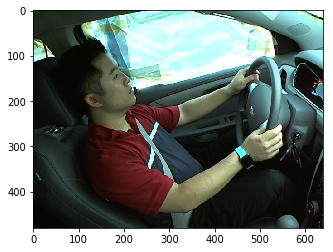

In [4]:
#Load an example photo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('../input/train/c0/img_4013.jpg')
imgplot = plt.imshow(img)
img.shape
plt.show()


In [5]:
#Find the largest and smallest dimensions of all the pictures
def findPictureDims(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                config.imgcount+=1
                filename = os.path.join(subdir, file)
                image = Image.open(filename)
                width, height = image.size
                if width < config.minwidth:
                    config.minwidth = width
                if height < config.minheight:
                    config.minheight = height
                if width > config.maxwidth:
                    config.maxwidth = width
                if height > config.maxheight:
                    config.maxheight = height
    return

In [6]:
#Count the number of files in each subdirectory
def listDirectoryCounts(path):
    d = []
    for subdir, dirs, files in os.walk(path,topdown=False):
        filecount = len(files)
        dirname = subdir
        d.append((dirname,filecount))
    return d 

In [7]:
def SplitCat(df):
    for index, row in df.iterrows():
        directory=row['Category'].split('/')
        if directory[3]!='':
            directory=directory[3]
            df.at[index,'Category']=directory
        else:
            df.drop(index, inplace=True)
    return

In [8]:
#Get image count per category
dirCount=listDirectoryCounts(config.data_dir)
categoryInfo = pd.DataFrame(dirCount, columns=['Category','Count'])
SplitCat(categoryInfo)
categoryInfo=categoryInfo.sort_values(by=['Category'])
print(categoryInfo.to_string(index=False))

Category  Count
     c0   2489
     c1   2267
     c2   2317
     c3   2346
     c4   2326
     c5   2312
     c6   2325
     c7   2002
     c8   1911
     c9   2129


In [9]:
#Print out mins and maxes and the image counts
findPictureDims(config.data_dir)
print("Minimum Width:\t",config.minwidth, "\tMinimum Height:",config.minheight)
print("Maximum Width:\t",config.maxwidth, "\tMaximum Height:",config.maxheight, "\tImage Count:\t",config.imgcount)

Minimum Width:	 640 	Minimum Height: 480
Maximum Width:	 640 	Maximum Height: 480 	Image Count:	 22424


## Analysis
-All of the data in the training directory is of the same height and width.
-The aspect ratio of the pictures is 4:3, so any adjustments are made should be close to that ratio (see configuration)


## Building the Model

In [10]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%matplotlib inline

# In[2]:


def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


# In[3]:


def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


# In[49]:


def ResNet50(input_shape = (224,224,3), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 5, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 5, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 5, [32, 32, 128], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=5, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=5, block='c')
    
    # AVGPOOL
    X = AveragePooling2D(pool_size=(5, 5), padding='valid')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


# In[50]:


model = ResNet50(input_shape = (224, 224, 3), classes = 10)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 4736        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________________

In [11]:
#Model Definition
def build_model():
    inputs = Input(shape=(config.img_width_adjust,config.img_height_adjust,3), name="input")
    
    #Convolution 1
    conv1 = Conv2D(128, kernel_size=(3,3), activation="relu", name="conv_1")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), name="pool_1")(conv1)

    #Convolution 2
    conv2 = Conv2D(64, kernel_size=(3,3), activation="relu", name="conv_2")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name="pool_2")(conv2)
    
    #Convolution 3
    conv3 = Conv2D(32, kernel_size=(3,3), activation="relu", name="conv_3")(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name="pool_3")(conv3)
    
    #Convolution 4
    conv4 = Conv2D(16, kernel_size=(3,3), activation="relu", name="conv_4")(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2), name="pool_4")(conv4)
    
    #Fully Connected Layer
    flatten = Flatten()(pool4)
    fc1 = Dense(1024, activation="relu", name="fc_1")(flatten)
    
    #output
    output=Dense(10, activation="softmax", name ="softmax")(fc1)
    
    # finalize and compile
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    return model
model1 = build_model()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 111, 111, 128)     0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 109, 109, 64)      73792     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 54, 54, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 52, 52, 32)        18464     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 26, 26, 32)        0         
__________

In [12]:
#Setup data, and create split for training, testing 80/20
def setup_data(train_data_dir, val_data_dir, img_width=config.img_width_adjust, img_height=config.img_height_adjust, batch_size=config.batch_size):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
        #Note uses training dataflow generator
    return train_generator, validation_generator

In [13]:
def fit_model(model, train_generator, val_generator, batch_size, epochs):
    model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        verbose=1)
    return model

#Verbose: 0: no output, 1: output with status bar, 2: Epochs Only

In [14]:
# Model Evaluation
def eval_model(model, val_generator, batch_size):
    scores = model.evaluate_generator(val_generator, steps=val_generator.samples // batch_size)
    print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))

In [15]:
# Create Data 80/20
train_generator, val_generator = setup_data(config.data_dir, config.data_dir, batch_size=config.batch_size)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [16]:
import time 

#let's also import the abstract base class for our callback
from keras.callbacks import Callback

#defining the callback
class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)

In [17]:
timerCallback = TimerCallback(350)
from keras.callbacks import ModelCheckpoint

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
batch_size = 16
model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // 16,
        epochs=config.epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // 16,
        verbose=1,callbacks = [timerCallback, ModelCheckpoint('my_weights.h5')])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1121/1121 [==============================] - 354s 316ms/step - loss: 1.8548 - acc: 0.3234 - val_loss: 0.8494 - val_acc: 0.7118
Epoch 2/50
1121/1121 [==============================] - 342s 305ms/step - loss: 0.5603 - acc: 0.8133 - val_loss: 0.3500 - val_acc: 0.8869
Epoch 3/50
1121/1121 [==============================] - 342s 305ms/step - loss: 0.3174 - acc: 0.8987 - val_loss: 0.2100 - val_acc: 0.9355
Epoch 4/50
1121/1121 [==============================] - 343s 306ms/step - loss: 0.2360 - acc: 0.9269 - val_loss: 0.1848 - val_acc: 0.9427
Epoch 5/50
1121/1121 [==============================] - 343s 306ms/step - loss: 0.1818 - acc: 0.9418 - val_loss: 0.2109 - val_acc: 0.9306
Epoch 6/50
1121/1121 [==============================] - 344s 307ms/step - loss: 0.1533 - acc: 0.9528 - val_loss: 0.1324 - val_acc: 0.9597
Epoch 7/50
1121/1121 [==============================] - 344s 307ms/step - loss: 0.1356 - acc: 0.9588 - val_loss: 0.1428 - va

## Evaluation

In [20]:
# Evaluate your model.
eval_model(model, val_generator, batch_size=config.batch_size)

Loss: 0.056475315139683895 Accuracy: 0.9876819708846585
